In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import pickle
import numpy as np
import matplotlib.pyplot as plt
import librosa
import seaborn as sns
import statsmodels.api as sm
from scipy import stats

In [3]:
# read data
train_df = pd.read_csv('../MELD.Raw/train/train_sent_emo.csv')
with open('../audio/train_data.pkl', 'rb') as f:
    train_audio_dict = pickle.load(f)

In [84]:
# set encoders
emotion_encoder = LabelEncoder()
sentiment_encoder = LabelEncoder()
emotion_encoder.fit(train_df['Emotion'])
sentiment_encoder.fit(train_df['Sentiment'])

In [85]:
emotion_distribution = train_df['Emotion'].value_counts(normalize=True)
emotion_distribution

In [86]:
sentiment_distribution = train_df['Sentiment'].value_counts(normalize=True)
sentiment_distribution

In [87]:
train_df['word_count'] = train_df['Utterance'].apply(lambda x: len(x.split()))

In [88]:
train_df.groupby('Emotion')['word_count'].mean()


In [13]:
top_10_speakers = train_df.groupby('Speaker', as_index=False)['Speaker'].size()
top_10_speakers = top_10_speakers.sort_values(by='size', ascending=False)
top_10_speakers = top_10_speakers['Speaker'].values[0:10]

In [18]:
# Calculate the count of each speaker
speaker_counts = train_df['Speaker'].value_counts()

# Create a DataFrame from the speaker counts
speaker_df = speaker_counts.reset_index()
speaker_df.columns = ['Speaker', 'Count']

# Calculate the total number of entries
total = speaker_df['Count'].sum()

# Calculate the proportion for each speaker
speaker_df['Proportion'] = speaker_df['Count'] / total

# Sort the DataFrame by the count and select the top 6
top_6_speakers = speaker_df.sort_values(by='Count', ascending=False).head(6)

# Display the DataFrame
print(top_6_speakers)
print((top_6_speakers['Proportion']).sum())

    Speaker  Count  Proportion
0      Joey   1509    0.151066
1      Ross   1459    0.146061
2    Rachel   1435    0.143658
3    Phoebe   1321    0.132245
4    Monica   1299    0.130043
5  Chandler   1283    0.128441
0.831514666132746


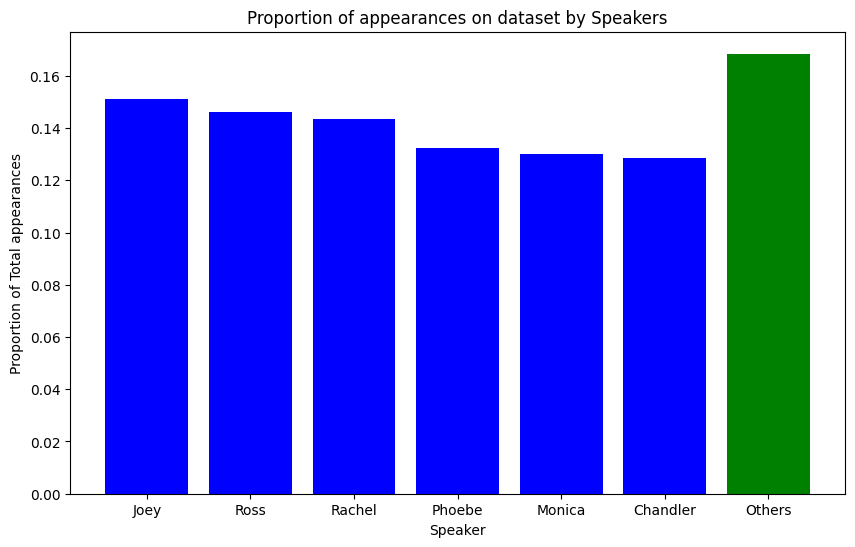

In [17]:
# Calculate the count of each speaker
speaker_counts = train_df['Speaker'].value_counts()

# Create a DataFrame from the speaker counts
speaker_df = speaker_counts.reset_index()
speaker_df.columns = ['Speaker', 'Count']

# Calculate the total number of entries
total = speaker_df['Count'].sum()

# Calculate the proportion for each speaker
speaker_df['Proportion'] = speaker_df['Count'] / total

# Sort the DataFrame by the count
speaker_df = speaker_df.sort_values(by='Count', ascending=False)

# Separate the top 6 speakers
top_6_speakers = speaker_df.head(6)

# Create an 'Others' category for all other speakers
others = pd.DataFrame(data = {
    'Speaker': ['Others'],
    'Count': [speaker_df['Count'][6:].sum()],
    'Proportion': [speaker_df['Proportion'][6:].sum()]
})

# Combine the top 6 speakers with 'Others'
plot_data = pd.concat([top_6_speakers, others])

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(plot_data['Speaker'], plot_data['Proportion'], color=['blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'green'])
plt.xlabel('Speaker')
plt.ylabel('Proportion of Total appearances')
plt.title('Proportion of appearances on dataset by Speakers')
plt.show()

In [14]:
top_10_speakers

array(['Joey', 'Ross', 'Rachel', 'Phoebe', 'Monica', 'Chandler', 'Janice',
       'Carol', 'Emily', 'Tag'], dtype=object)

In [91]:
train_df_top_10 = train_df[train_df['Speaker'].isin(top_10_speakers)]

In [92]:
train_df_top_10.groupby('Speaker',)['word_count'].mean()

In [93]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# Function to generate and display word clouds
def generate_word_clouds(df, column):
    # Unique categories
    categories = df[column].unique()
    
    # Figure setup
    plt.figure(figsize=(20, 10))
    
    # Generate a word cloud for each category
    for i, category in enumerate(categories, 1):
        # Aggregate text for the current category
        text = " ".join(df[df[column] == category]['Utterance'].tolist())
        
        # Generate word cloud
        wordcloud = WordCloud(width=400, height=300, background_color='white').generate(text)
        
        # Plot
        plt.subplot(1, len(categories), i)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'{category} {column}')
        plt.axis('off')
    
    plt.show()


In [94]:
generate_word_clouds(train_df, 'Sentiment')

In [95]:
generate_word_clouds(train_df_top_10, 'Sentiment')

generate_word_clouds(train_df_top_10, 'Emotion')

In [97]:
generate_word_clouds(train_df, 'Emotion')


In [98]:
generate_word_clouds(train_df_top_10, 'Speaker')

**Audio Features Descriptive Statistics**

**First Version - simple audio features with 3 classes**

In [3]:
#with open('../audio/dev_data.pkl','rb') as file:
#    dev_audio_dict = pickle.load(file)

#with open('../audio/test_data.pkl','rb') as file:
#    test_audio_dict = pickle.load(file)

with open('../AudioFeaturesExtraction/train_data.pkl','rb') as file:
    train_audio_dict = pickle.load(file)

In [4]:
def extract_features(waveform, sr):
    """
    Calculate various spectral features and return them in a dictionary.
    """
    # Basic spectral features
    spectral_centroid = librosa.feature.spectral_centroid(y=waveform, sr=sr)[0]
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=waveform, sr=sr)[0]
    spectral_flatness = librosa.feature.spectral_flatness(y=waveform)[0]
    spectral_rolloff = librosa.feature.spectral_rolloff(y=waveform, sr=sr)[0]
    rms_energy = librosa.feature.rms(y=waveform)[0]
    zcr = librosa.feature.zero_crossing_rate(waveform)[0]
    mfccs = librosa.feature.mfcc(y=waveform, sr=sr)
    chroma = librosa.feature.chroma_stft(y=waveform, sr=sr)

    # Initialize the feature dictionary
    features = {
        'centroid_mean': np.mean(spectral_centroid),
        'bandwidth_mean': np.mean(spectral_bandwidth),
        'flatness_mean': np.mean(spectral_flatness),
        'rolloff_mean': np.mean(spectral_rolloff),
        'rms_energy_mean': np.mean(rms_energy),
        'zcr_mean': np.mean(zcr)
    }

    # Adding MFCCs and Chroma features
    for i in range(mfccs.shape[0]):  # Assuming MFCCs are returned with shape (n_mfcc, t)
        features[f'mfccs_mean_{i}'] = np.mean(mfccs[i, :])

    for i in range(chroma.shape[0]):  # Assuming Chroma features are returned with shape (n_chroma, t)
        features[f'chroma_mean_{i}'] = np.mean(chroma[i, :])

    return features

def process_audio_data(audio_dict, sample_rate):
    """
    Process each audio scene, extract features, and compile them into a single DataFrame.
    """
    feature_list = []

    for scene_id, data in audio_dict.items():
        waveform = data['waveforms'][0].numpy()  # Ensure waveform is a NumPy array
        features = extract_features(waveform, sample_rate)
        features['scene_id'] = scene_id  # Add scene_id to the features dictionary
        feature_list.append(features)
    
    # Create a DataFrame from the list of feature dictionaries
    combined_features_df = pd.DataFrame(feature_list)
    return combined_features_df

sample_rate = 16000  # Common sample rate for high-quality audio
#dev_feature_data = process_audio_data(dev_audio_dict, sample_rate)
#test_feature_data = process_audio_data(test_audio_dict, sample_rate)
train_feature_data = process_audio_data(train_audio_dict, sample_rate)

#print(dev_feature_data.head())
#print(test_feature_data.head())
print(train_feature_data.head())

In [44]:
dev = pd.read_csv('dev_fe_16000.csv')

In [45]:
def file_key_generator(file_path, labels_dict):
    info_file = pd.read_csv(file_path)
    # Creating file_key which is a unique identifier for each scene.
    info_file['file_key'] = 'dia' + info_file['Dialogue_ID'].astype(str) + '_' + 'utt' + info_file[
        'Utterance_ID'].astype(str)

    info_file['label'] = info_file['Sentiment'].map(labels_dict)
    info_file = info_file.sort_values(by='file_key')
    return info_file

labels_dict = {
            'negative': 0,
            'neutral': 1,
            'positive': 0}
file_path = '/Users/orl/studies/statistical learning/nlp-with-audio/MELD.Raw/train/train_sent_emo.csv'

dev_info_file = file_key_generator(file_path, labels_dict)

In [46]:
dev_joined_with_audio = dev.merge(dev_info_file[['file_key', 'label']], left_on = 'scene_id', right_on = 'file_key')
dev_joined_with_audio = dev_joined_with_audio.drop(columns=['Unnamed: 0'])
dev_joined_with_audio = dev_joined_with_audio.drop(columns=['fourier_tempogram_mean', 'poly_features_0', 'poly_features_1', 'poly_features_2'])

In [47]:
dev_joined_with_audio.columns

In [48]:
num_cols = ['centroid_median', 'bandwidth_median', 'flatness_median',
       'rolloff_median', 'rms_energy_median', 'zcr_median', 'tempo',
       'tempogram_median', 'tempogram_ratio_median', 'tonnetz_median',
       'mfccs_median_0', 'mfccs_median_1', 'mfccs_median_2', 'mfccs_median_3',
       'mfccs_median_4', 'mfccs_median_5', 'mfccs_median_6', 'mfccs_median_7',
       'mfccs_median_8', 'mfccs_median_9', 'mfccs_median_10',
       'mfccs_median_11', 'mfccs_median_12', 'mfccs_median_13',
       'mfccs_median_14', 'mfccs_median_15', 'mfccs_median_16',
       'mfccs_median_17', 'mfccs_median_18', 'mfccs_median_19',
       'chroma_median_0', 'chroma_median_1', 'chroma_median_2',
       'chroma_median_3', 'chroma_median_4', 'chroma_median_5',
       'chroma_median_6', 'chroma_median_7', 'chroma_median_8',
       'chroma_median_9', 'chroma_median_10', 'chroma_median_11']
df_cor = dev_joined_with_audio[num_cols].corr(method='spearman')

In [49]:
dev_joined_with_audio['label'].value_counts(normalize=True)

In [50]:
dev_joined_with_audio['label'].value_counts(normalize=True)

In [51]:
features = dev_joined_with_audio.columns[:-3]

# Set the aesthetics for the plots
sns.set(style='whitegrid')

# Create a figure to hold the plots
fig, axes = plt.subplots(10, 4, figsize=(20, 50))  # Adjust the layout size as necessary
axes = axes.flatten()  # Flatten the 2D array of axes

for i, feature in enumerate(features):
    # Plot each feature by label in the same subplot
    sns.histplot(data=dev_joined_with_audio, x=feature, hue='label', element='step', stat='density', common_norm=False, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature} by label')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Density')

# Adjust layout to prevent overlap and save the figure if needed
plt.tight_layout()
plt.show()

**Second Version - simple audio features with 2 classes**

In [53]:
# Assuming 'df' is your DataFrame after joining and cleaning
features = dev_joined_with_audio.columns[:-3]
print(features)
label = dev_joined_with_audio['label']

log_likelihoods = []

for feature in features:
    # Prepare the feature data with an intercept
    X = sm.add_constant(dev_joined_with_audio[feature])  # Adds a constant term to the feature
    y = label

    # Fit logistic regression model
    model = sm.Logit(y, X).fit(disp=0)  # disp=0 turns off the fitting summary output

    # Store the log-likelihood
    log_likelihoods.append(model.llf)  # llf is the log likelihood of the fitted model

# Create a DataFrame to sort features by log-likelihood
results = pd.DataFrame({
    'Feature': features,
    'Log-Likelihood': log_likelihoods
}).sort_values(by='Log-Likelihood', ascending=True)

import matplotlib.pyplot as plt

# Assuming 'results' DataFrame from your code is already prepared and sorted

# Plotting
plt.figure(figsize=(10, 8))
# Scatter plot where we use the index as the y-value and log-likelihood as the x-value
plt.scatter(results['Log-Likelihood'], range(len(results['Feature'])), color='b')

# Setting the y-ticks to show feature names
plt.yticks(range(len(results['Feature'])), results['Feature'])

plt.title('Log-Likelihood of Logistic Regression Models by Feature')
plt.xlabel('Log-Likelihood')
plt.ylabel('Feature')
plt.show()

In [58]:
best_features = results.tail(12)['Feature'].values.tolist()
best_features

**Third Version - more audio features**

In [9]:
def extract_features(waveform, sr):
    """
    Calculate various spectral, rhythmic, and tonal features and return them in a dictionary.
    """
    # Decompose into harmonic and percussive components
    harmonic, percussive = librosa.effects.hpss(waveform)

    # Temporal and spectral features
    tempo, _ = librosa.beat.beat_track(y=waveform, sr=sr)
    onset_env = librosa.onset.onset_strength(y=waveform, sr=sr)
    tempogram = librosa.feature.tempogram(onset_envelope=onset_env, sr=sr)
    fourier_tempogram = librosa.feature.fourier_tempogram(onset_envelope=onset_env, sr=sr)
    tempogram_ratio = librosa.feature.tempogram(onset_envelope=onset_env, sr=sr, win_length=16)
    p_features = librosa.feature.poly_features(S=librosa.stft(waveform), sr=sr, order=2)
    tonnetz = librosa.feature.tonnetz(y=harmonic, sr=sr)

    # Basic spectral features
    spectral_centroid = librosa.feature.spectral_centroid(y=waveform, sr=sr)[0]
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=waveform, sr=sr)[0]
    spectral_flatness = librosa.feature.spectral_flatness(y=waveform)[0]
    spectral_rolloff = librosa.feature.spectral_rolloff(y=waveform, sr=sr)[0]
    rms_energy = librosa.feature.rms(y=waveform)[0]
    zcr = librosa.feature.zero_crossing_rate(waveform)[0]
    mfccs = librosa.feature.mfcc(y=waveform, sr=sr)
    chroma = librosa.feature.chroma_stft(y=waveform, sr=sr)

    # Initialize the feature dictionary
    features = {
        'centroid_mean': np.mean(spectral_centroid),
        'bandwidth_mean': np.mean(spectral_bandwidth),
        'flatness_mean': np.mean(spectral_flatness),
        'rolloff_mean': np.mean(spectral_rolloff),
        'rms_energy_mean': np.mean(rms_energy),
        'zcr_mean': np.mean(zcr),
        'tempo': tempo,
        'tempogram_mean': np.mean(tempogram),
        'fourier_tempogram_mean': np.mean(fourier_tempogram),
        'tempogram_ratio_mean': np.mean(tempogram_ratio),
        'tonnetz_mean': np.mean(tonnetz)
    }

    # Adding MFCCs and Chroma features
    for i in range(mfccs.shape[0]):
        features[f'mfccs_mean_{i}'] = np.mean(mfccs[i, :])

    for i in range(chroma.shape[0]):
        features[f'chroma_mean_{i}'] = np.mean(chroma[i, :])

    # Adding Polynomial features
    for i in range(p_features.shape[0]):
        features[f'poly_features_{i}'] = np.mean(p_features[i, :])

    return features

def process_audio_data(audio_dict, sample_rate):
    """
    Process each audio scene, extract features, and compile them into a single DataFrame.
    """
    feature_list = []

    for scene_id, data in audio_dict.items():
        waveform = data['waveforms'][0].numpy()  # Ensure waveform is a NumPy array
        features = extract_features(waveform, sample_rate)
        features['scene_id'] = scene_id  # Add scene_id to the features dictionary
        feature_list.append(features)
    
    # Create a DataFrame from the list of feature dictionaries
    combined_features_df = pd.DataFrame(feature_list)
    return combined_features_df

sample_rate = 16000  # Common sample rate for high-quality audio
# Example of usage in your pipeline
train_feature_data = process_audio_data(train_audio_dict, sample_rate)
print(train_feature_data.head())

      file_key  label
0    dia0_utt0      1
1    dia0_utt1      1
10  dia0_utt10      0
11  dia0_utt11      1
12  dia0_utt12      2
   audio_feature_centroid_mean  audio_feature_bandwidth_mean  \
0                   869.897864                    875.088568   
1                   653.885841                    646.922045   
2                   668.150410                    692.430935   
3                   841.240666                    852.317232   
4                  1298.317909                   1131.438863   

   audio_feature_flatness_mean  audio_feature_rolloff_mean  \
0                     0.005770                 1684.788813   
1                     0.393277                 1257.170377   
2                     0.184604                 1259.560502   
3                     0.005144                 1590.646404   
4                     0.009890                 2482.555651   

   audio_feature_rms_energy_mean  audio_feature_zcr_mean  audio_feature_tempo  \
0                       0.042

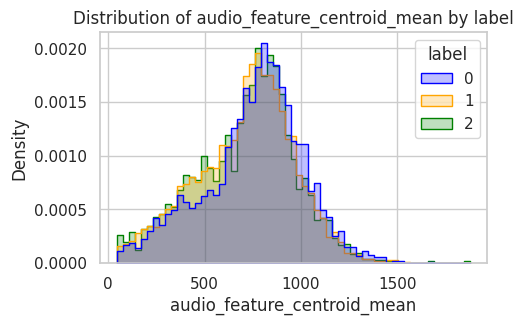

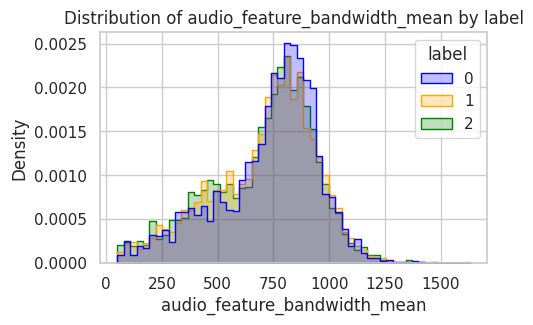

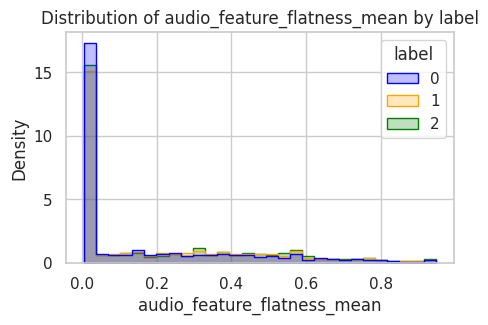

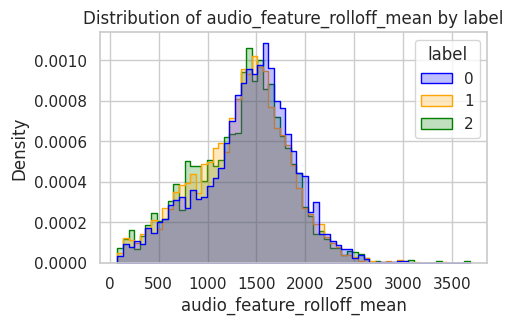

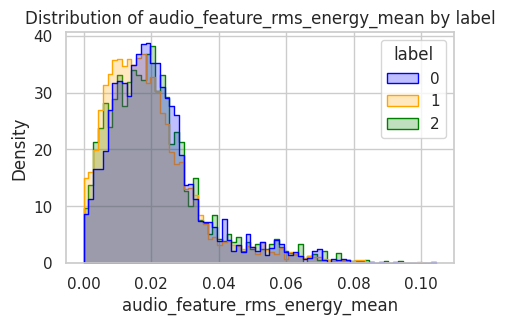

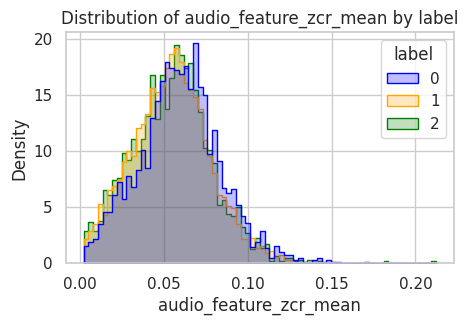

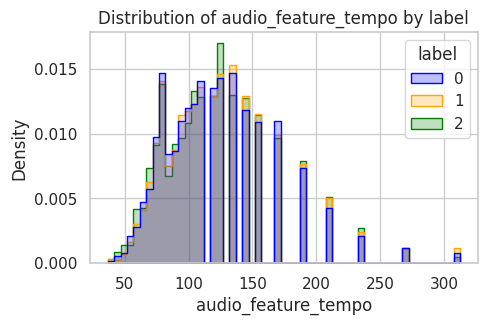

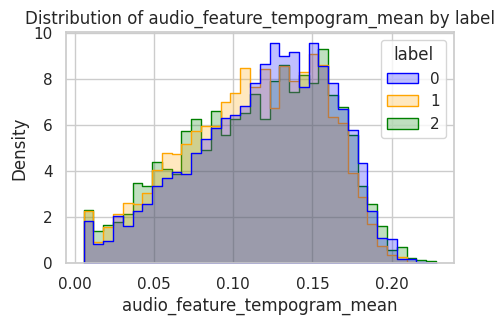

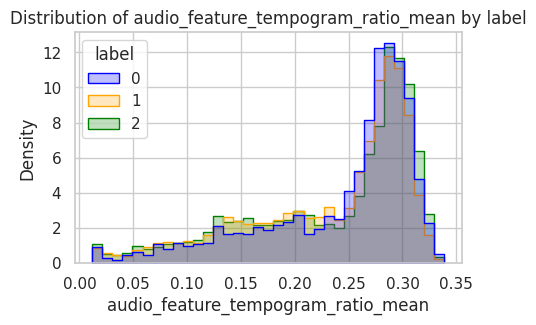

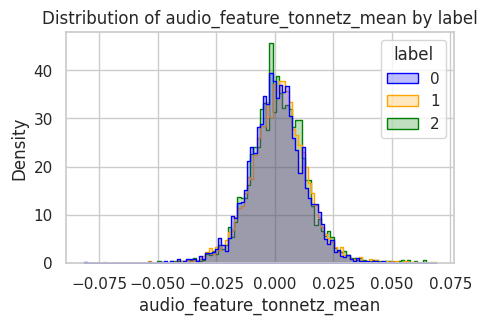

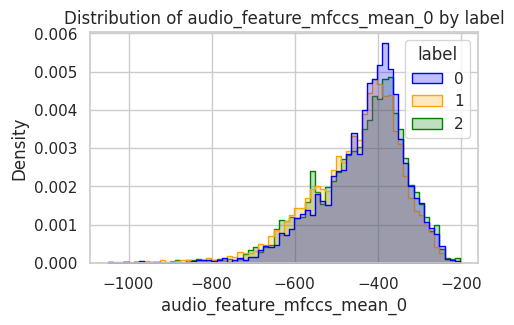

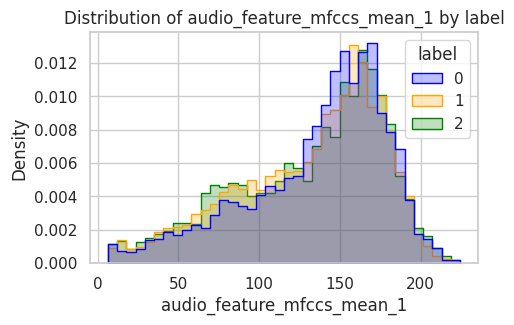

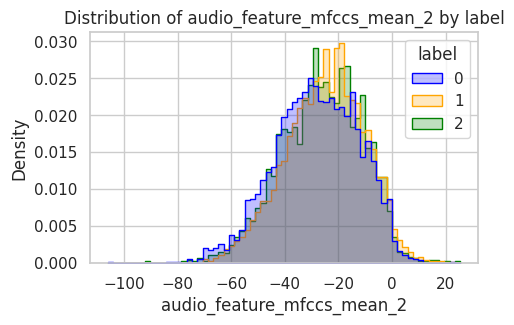

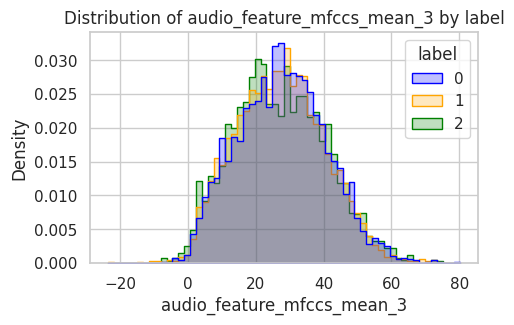

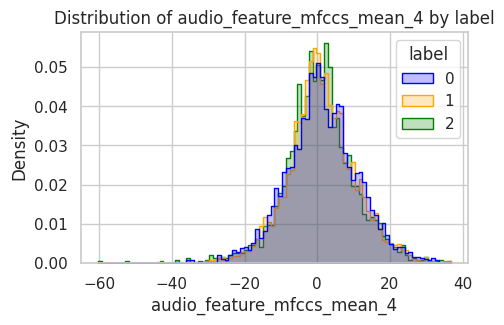

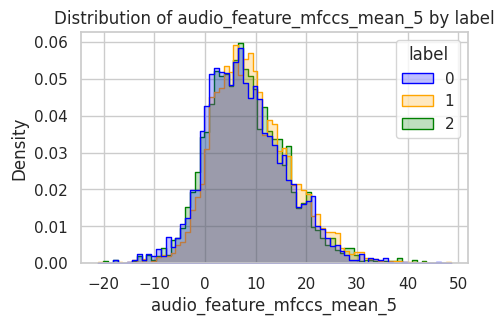

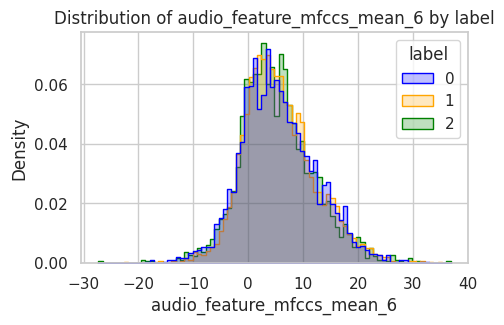

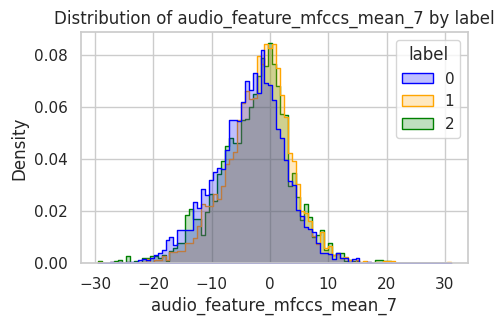

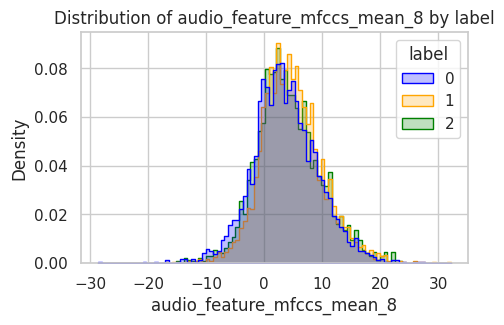

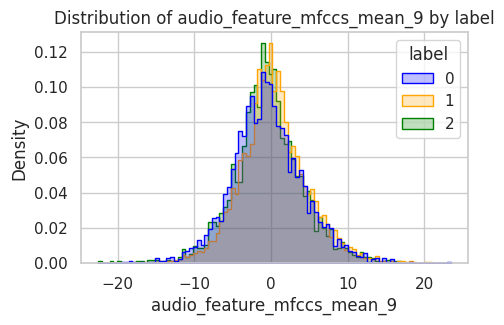

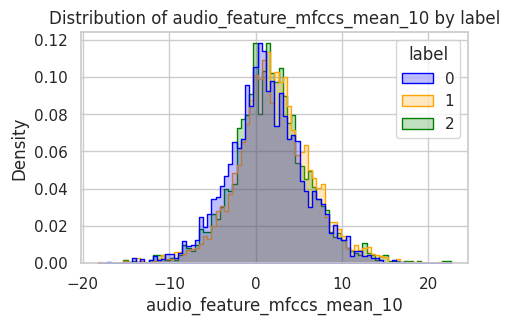

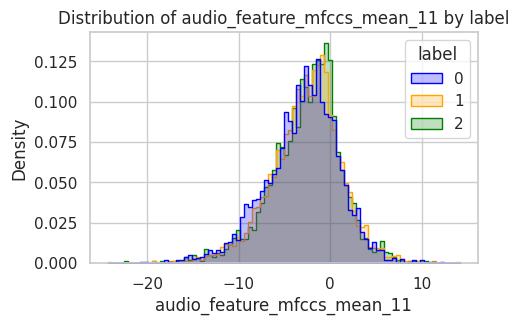

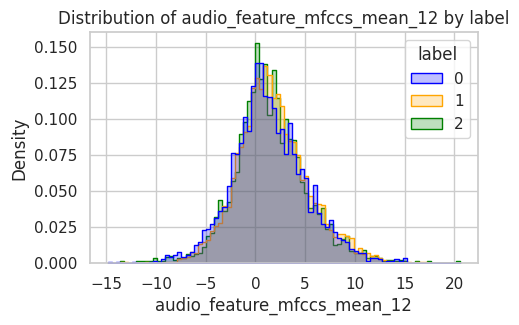

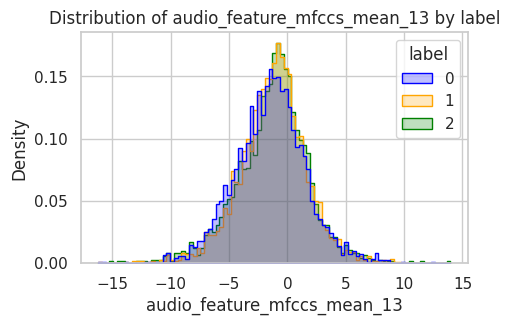

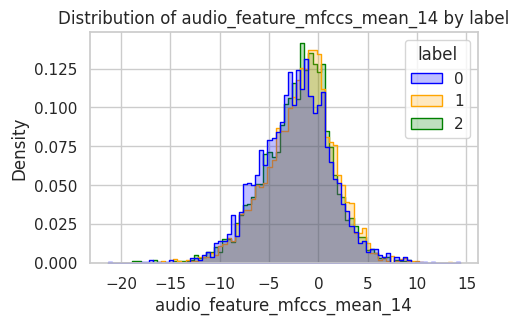

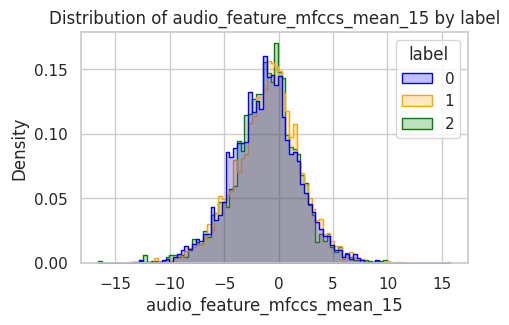

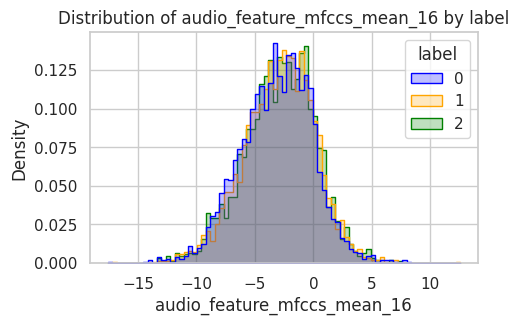

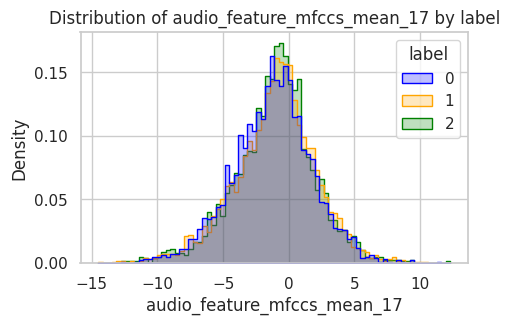

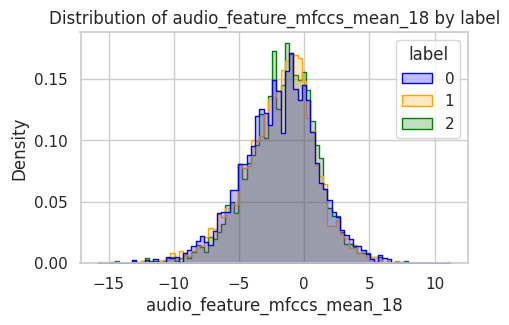

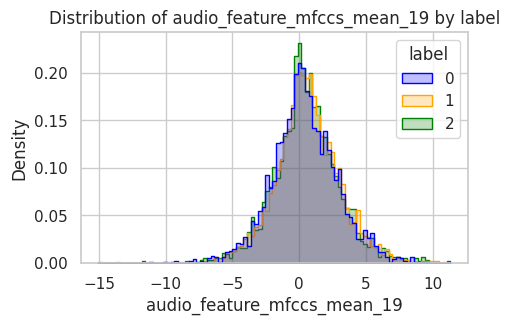

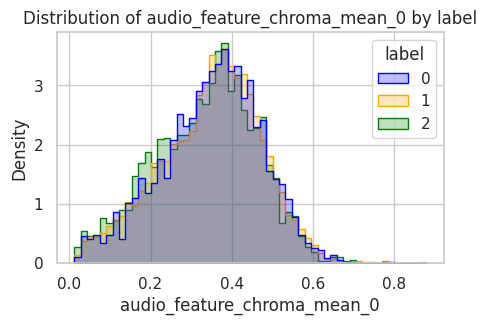

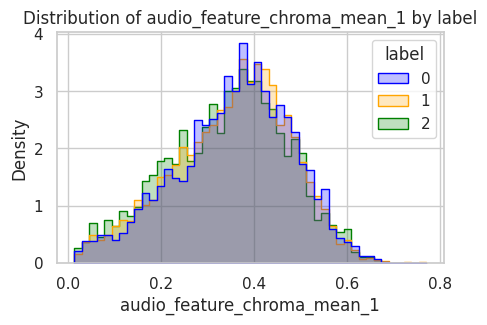

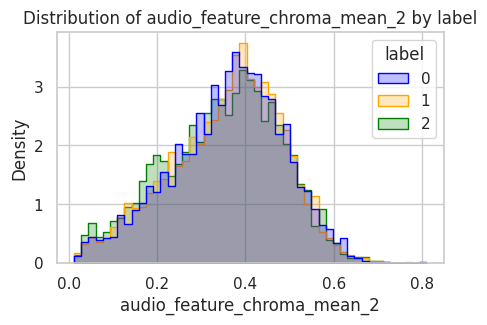

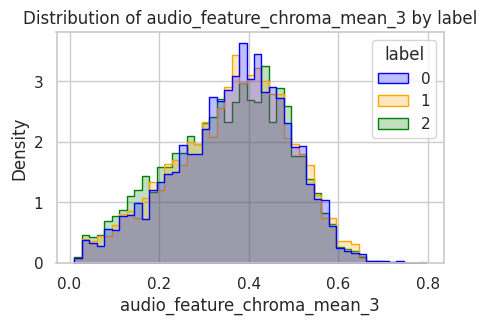

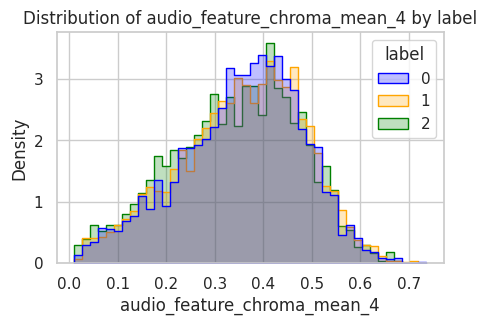

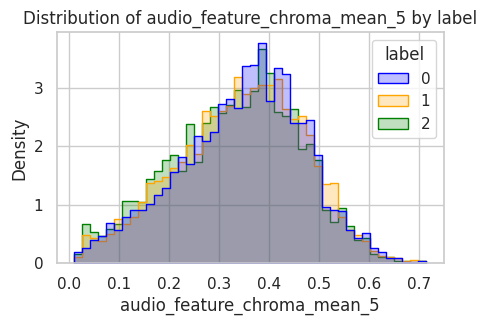

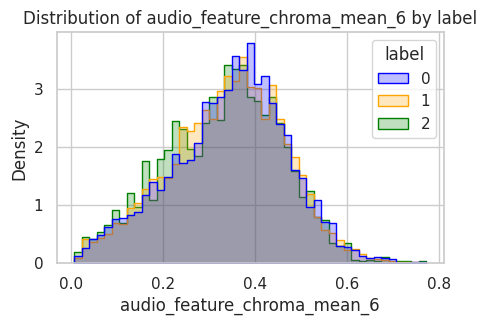

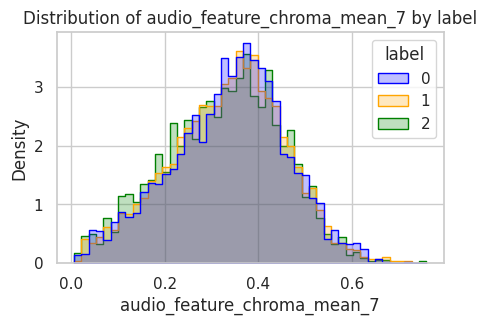

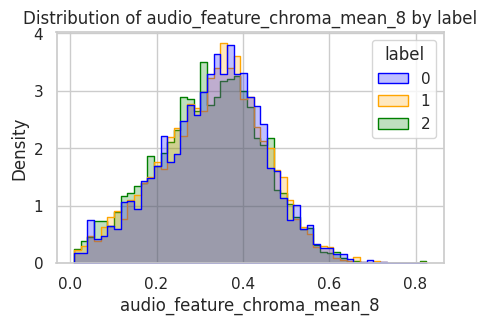

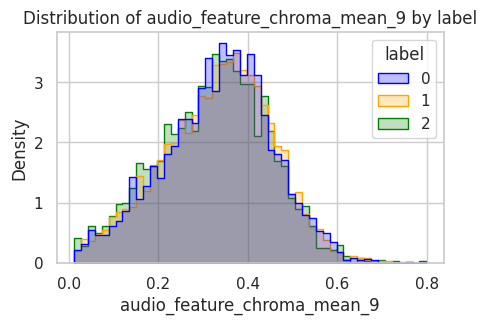

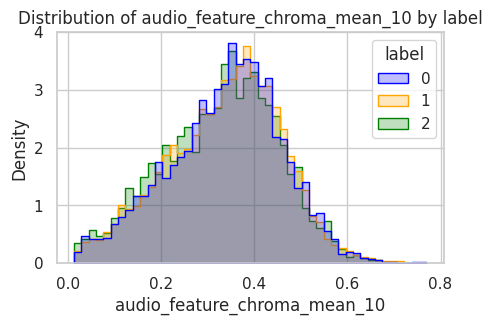

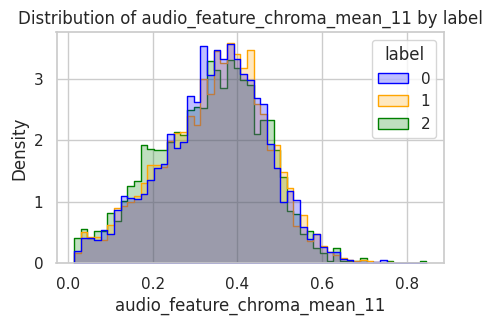

In [7]:
def file_key_generator(file_path, labels_dict):
    info_file = pd.read_csv(file_path)
    # Creating file_key which is a unique identifier for each scene.
    info_file['file_key'] = 'dia' + info_file['Dialogue_ID'].astype(str) + '_' + 'utt' + info_file[
        'Utterance_ID'].astype(str)

    info_file['label'] = info_file['Sentiment'].map(labels_dict)
    info_file = info_file.sort_values(by='file_key')
    return info_file

labels_dict = {
            'negative': 0,
            'neutral': 1,
            'positive': 2}
file_path = '../MELD.Raw/train/train_sent_emo.csv'

train_info_file = file_key_generator(file_path, labels_dict)
train_info_file_subset = train_info_file[['file_key','label']]
print(train_info_file_subset.head())

features_data = pd.read_csv('../audio/train_fe.csv')
audio_features= [col for col in features_data.columns if col.startswith('audio_feature_')]
all_features = audio_features + ['file_key']
audio_features_data = features_data[all_features]
print(audio_features_data.head())
train_joined_with_audio = audio_features_data.merge(train_info_file_subset, left_on = 'file_key', right_on = 'file_key')
print(train_joined_with_audio.head())



# Set the aesthetics for the plots
sns.set(style='whitegrid')
palette = {0: 'blue', 1: 'orange', 2: 'green'}

# Enumerate over each feature in your list of audio features
for i, feature in enumerate(audio_features):
    # Create a new figure for each plot
    plt.figure(figsize=(5, 3))  # You can adjust the figure size as necessary

    # Plot each feature by label
    sns.histplot(data=train_joined_with_audio, x=feature, hue='label', element='step', stat='density', common_norm=False, palette = palette)
    
    # Set the title and labels for each plot
    plt.title(f'Distribution of {feature} by label')
    plt.xlabel(f'{feature}')
    plt.ylabel('Density')
    
    # Show the plot
    plt.show()

    # Optionally, if you want to save each figure to a file
    # plt.savefig(f'path/to/save/{feature}_distribution.png')  

In [67]:
# Assuming 'df' is your DataFrame after joining and cleaning
features = train_joined_with_audio.columns[:-3]
label = train_joined_with_audio['label']

log_likelihoods = []

for feature in features:
    # Prepare the feature data with an intercept
    X = sm.add_constant(train_joined_with_audio[feature])  # Adds a constant term to the feature
    y = label

    # Fit logistic regression model
    model = sm.Logit(y, X).fit(disp=0)  # disp=0 turns off the fitting summary output

    # Store the log-likelihood
    log_likelihoods.append(model.llf)  # llf is the log likelihood of the fitted model

# Create a DataFrame to sort features by log-likelihood
results = pd.DataFrame({
    'Feature': features,
    'Log-Likelihood': log_likelihoods
}).sort_values(by='Log-Likelihood', ascending=False)

# Plotting
plt.figure(figsize=(10, 8))
sns.barplot(x='Log-Likelihood', y='Feature', data=results)
plt.title('Log-Likelihood of Logistic Regression Models by Feature')
plt.xlabel('Log-Likelihood')
plt.ylabel('Feature')
plt.show()

ValueError: endog must be in the unit interval.

In [ ]:
def positive_fft(waveform, sr):
    """
    This function computes the FFT of a waveform and returns the positive frequency components and their magnitudes.
    
    Parameters:
    - waveform: The audio waveform array.
    - sr: Sample rate of the audio data.
    
    Returns:
    - pos_frequencies: Positive frequency values.
    - pos_magnitudes: Magnitudes of the FFT at positive frequencies.
    """
    fft_values = np.fft.fft(waveform)
    frequencies = np.fft.fftfreq(len(waveform), 1/sr)
    
    # Filter positive frequencies
    mask = frequencies >= 0
    pos_frequencies = frequencies[mask]
    pos_magnitudes = np.abs(fft_values[mask])
    
    return pos_frequencies, pos_magnitudes

In [ ]:
def plot_average_fft(audio_dict, sample_rate):
    sum_fft = None
    count = 0

    for scene_id, data in audio_dict.items():
        waveform = data['waveforms'][0].numpy()
        pos_frequencies, pos_magnitudes = positive_fft(waveform, sample_rate)
        
        # Initialize sum_fft if it's the first scene
        if sum_fft is None:
            sum_fft = np.zeros_like(pos_magnitudes)
        
        # Sum the FFT magnitudes
        sum_fft += pos_magnitudes
        count += 1

    # Calculate average FFT
    avg_fft = sum_fft / count

    # Plot the average FFT
    plt.figure(figsize=(10, 5))
    plt.plot(pos_frequencies, avg_fft)
    plt.title('Average FFT Across All Scenes')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Average Amplitude')
    plt.show()

plot_average_fft(dev_audio_dict, 44100)

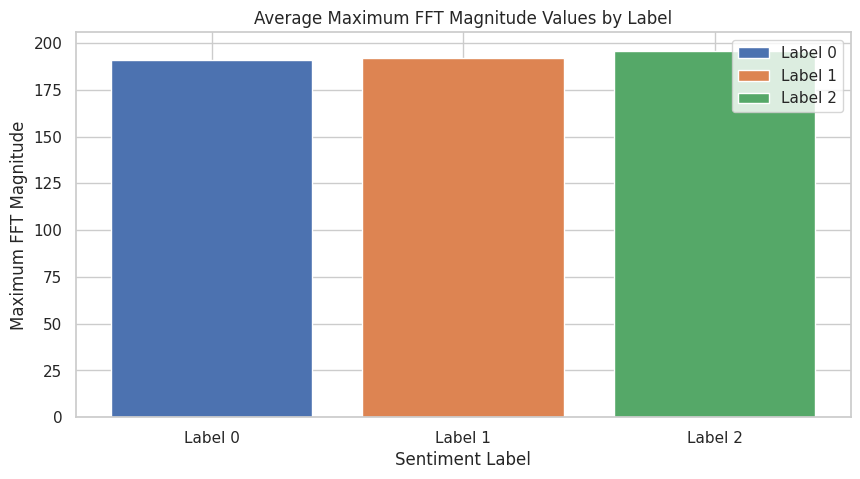

In [57]:
def plot_filtered_maxima_by_label(audio_dict, sr, max_freq=5000):
    """
    Computes and plots the maximum FFT magnitude values of waveforms in the audio dictionary, separated by labels, up to a specified maximum frequency.
    
    Parameters:
    - audio_dict: Dictionary containing multiple audio data entries. Each entry is expected to have 'waveforms' key with an audio waveform array and 'label' key with the category.
    - sr: Sample rate of the audio data.
    - max_freq: The maximum frequency to consider for filtering.
    """
    max_values = {0: [], 1: [], 2: []}

    for scene_id, data in audio_dict.items():
        label = data['label'].item()  # get the label
        waveform = data['waveforms'][0].numpy()  # extract the first channel waveform and convert to numpy array if necessary
        fft_values = np.fft.fft(waveform)
        frequencies = np.fft.fftfreq(len(waveform), 1 / sr)
        magnitudes = np.abs(fft_values)
        
        # Filter to only consider frequencies up to max_freq
        mask = (frequencies >= 0) & (frequencies <= max_freq)
        filtered_magnitudes = magnitudes[mask]

        # Find the maximum magnitude within the filtered range
        if len(filtered_magnitudes) > 0:
            max_values[label].append(np.max(filtered_magnitudes))

    # Plotting all labels on the same plot for max values
    plt.figure(figsize=(10, 5))
    for label in max_values:
        if max_values[label]:  # only plot if there are max values for this label
            avg_max = np.mean(max_values[label])
            plt.bar(f'Label {label}', avg_max, label=f'Label {label}')
    
    plt.title('Average Maximum FFT Magnitude Values by Label')
    plt.xlabel('Sentiment Label')
    plt.ylabel('Maximum FFT Magnitude')
    plt.grid(True)
    plt.legend()
    plt.show()

# Example usage
plot_filtered_maxima_by_label(train_audio_dict, 44100, 2000)

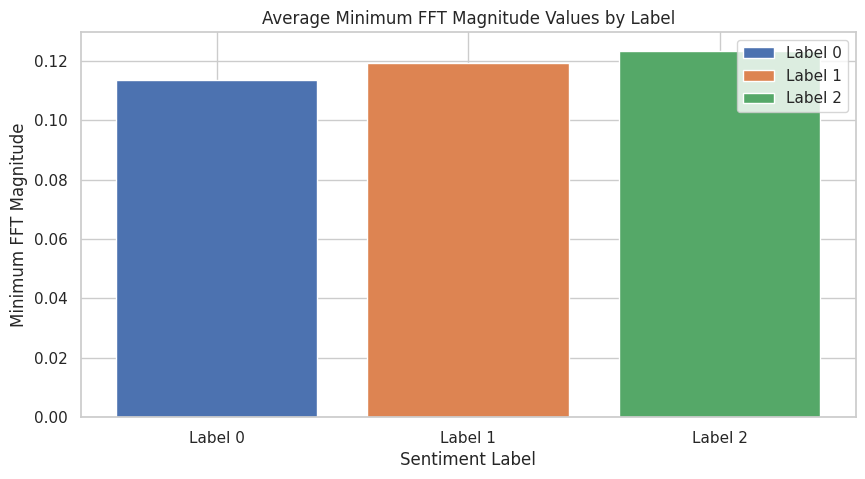

In [58]:
def plot_filtered_minima_by_label(audio_dict, sr, max_freq=5000):
    """
    Computes and plots the minimum FFT magnitude values of waveforms in the audio dictionary, separated by labels, up to a specified maximum frequency.
    
    Parameters:
    - audio_dict: Dictionary containing multiple audio data entries. Each entry is expected to have 'waveforms' key with an audio waveform array and 'label' key with the category.
    - sr: Sample rate of the audio data.
    - min_freq: The minimum frequency to consider for filtering.
    """
    min_values = {0: [], 1: [], 2: []}

    for scene_id, data in audio_dict.items():
        label = data['label'].item()  # get the label
        waveform = data['waveforms'][0].numpy()  # extract the first channel waveform and convert to numpy array if necessary
        fft_values = np.fft.fft(waveform)
        frequencies = np.fft.fftfreq(len(waveform), 1 / sr)
        magnitudes = np.abs(fft_values)
        
        # Filter to only consider frequencies up to max_freq
        mask = (frequencies >= 0) & (frequencies <= max_freq)
        filtered_magnitudes = magnitudes[mask]

        # Find the minimum magnitude within the filtered range
        if len(filtered_magnitudes) > 0:
            min_values[label].append(np.min(filtered_magnitudes))

    # Plotting all labels on the same plot for max values
    plt.figure(figsize=(10, 5))
    for label in min_values:
        if min_values[label]:  # only plot if there are max values for this label
            avg_min = np.mean(min_values[label])
            plt.bar(f'Label {label}', avg_min, label=f'Label {label}')
    
    plt.title('Average Minimum FFT Magnitude Values by Label')
    plt.xlabel('Sentiment Label')
    plt.ylabel('Minimum FFT Magnitude')
    plt.grid(True)
    plt.legend()
    plt.show()

# Example usage
plot_filtered_minima_by_label(train_audio_dict, 44100, 2000)

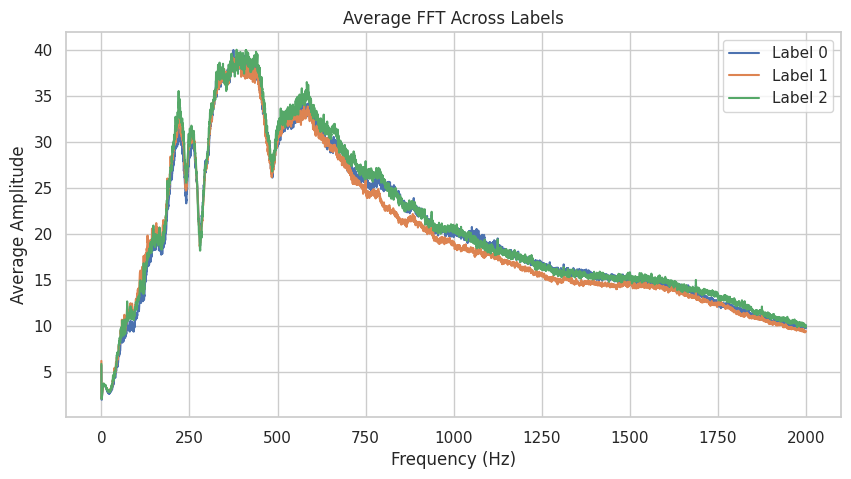

In [44]:
def plot_average_filtered_fft_by_label(audio_dict, sr, max_freq=5000):
    """
    Computes and plots the average FFT of multiple waveforms stored in a dictionary, separated by labels, up to a specified maximum frequency.
    
    Parameters:
    - audio_dict: Dictionary containing multiple audio data entries. Each entry is expected to have 'waveforms' key with an audio waveform array and 'label' key with the category.
    - sr: Sample rate of the audio data.
    - max_freq: The maximum frequency to display in the plot.
    """
    sum_ffts = {0: None, 1: None, 2: None}
    counts = {0: 0, 1: 0, 2: 0}

    for scene_id, data in audio_dict.items():
        label = data['label'].item()  # get the label
        waveform = data['waveforms'][0].numpy()  # extract the first channel waveform and convert to numpy array if necessary
        fft_values = np.fft.fft(waveform)
        frequencies = np.fft.fftfreq(len(waveform), 1 / sr)
        magnitudes = np.abs(fft_values)
        
        # Filter to only show up to max_freq
        mask = (frequencies >= 0) & (frequencies <= max_freq)
        filtered_frequencies = frequencies[mask]
        filtered_magnitudes = magnitudes[mask]
        
        # Initialize sum_fft for the label if it's the first scene for that label
        if sum_ffts[label] is None:
            sum_ffts[label] = np.zeros_like(filtered_magnitudes)
        
        # Sum the FFT magnitudes for the label
        sum_ffts[label] += filtered_magnitudes
        counts[label] += 1

    # Plotting all labels on the same plot
    plt.figure(figsize=(10, 5))
    for label in sum_ffts:
        if counts[label] > 0:  # only plot if there are waveforms for this label
            avg_fft = sum_ffts[label] / counts[label]
            plt.plot(filtered_frequencies, avg_fft, label=f'Label {label}')
    
    plt.title('Average FFT Across Labels')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Average Amplitude')
    plt.grid(True)
    plt.ticks()
    plt.legend()
    plt.show()

# Example usage
plot_average_filtered_fft_by_label(train_audio_dict, 44100, 2000)

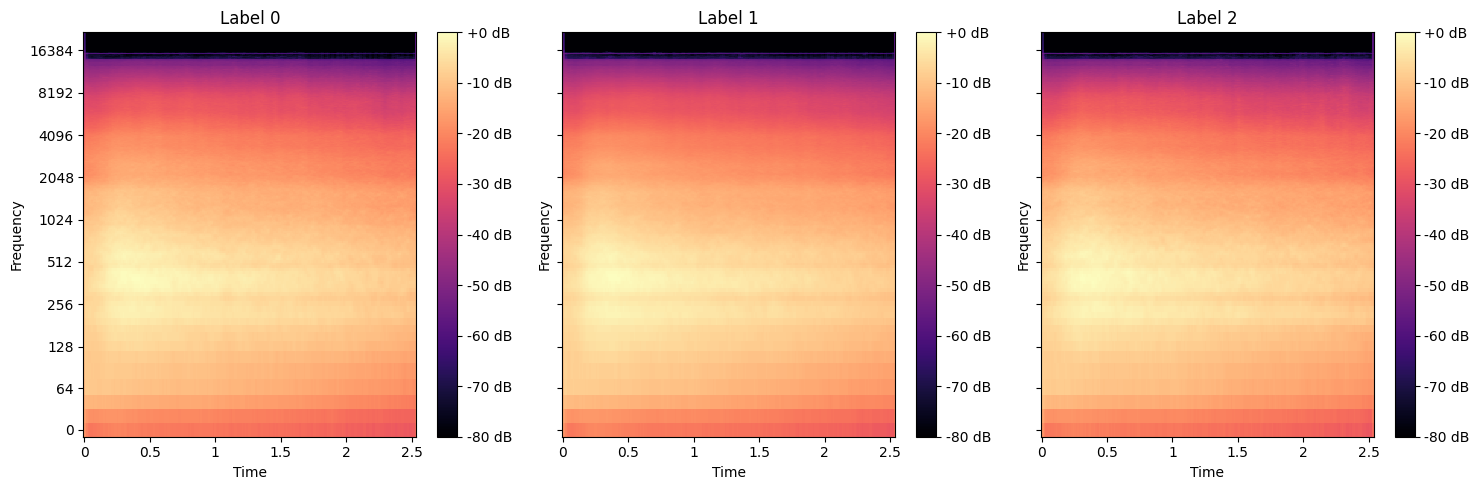

In [4]:
def plot_average_spectrogram_by_label(audio_dict, sr, n_fft=2048, hop_length=512):
    """
    Computes and plots the average spectrogram of multiple waveforms stored in a dictionary, separated by labels.
    
    Parameters:
    - audio_dict: Dictionary containing audio data entries. Each entry is expected to have 'waveforms' key with an audio waveform array and 'label' key with the category.
    - sr: Sample rate of the audio data.
    - n_fft: Number of FFT components.
    - hop_length: Number of samples between successive frames.
    """
    sum_spectrograms = {0: None, 1: None, 2: None}
    counts = {0: 0, 1: 0, 2: 0}

    for scene_id, data in audio_dict.items():
        label = data['label'].item()  # get the label
        waveform = data['waveforms'][0].numpy()  # extract the first channel waveform and convert to numpy array if necessary
        
        # Compute the spectrogram
        S = np.abs(librosa.stft(waveform, n_fft=n_fft, hop_length=hop_length))
        
        # Initialize sum_spectrogram for the label if it's the first scene for that label
        if sum_spectrograms[label] is None:
            sum_spectrograms[label] = np.zeros_like(S)
        
        # Sum the spectrogram for the label
        sum_spectrograms[label] += S
        counts[label] += 1

    # Plotting all labels
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    for label, ax in zip(sum_spectrograms, axes):
        if counts[label] > 0:  # only plot if there are waveforms for this label
            avg_spectrogram = sum_spectrograms[label] / counts[label]
            img = librosa.display.specshow(librosa.amplitude_to_db(avg_spectrogram, ref=np.max),
                                           sr=sr, hop_length=hop_length, x_axis='time', y_axis='log', ax=ax)
            ax.set_title(f'Label {label}')
            ax.set_xlabel('Time')
            ax.set_ylabel('Frequency')
            fig.colorbar(img, ax=ax, format="%+2.0f dB")
    
    plt.tight_layout()
    plt.show()

# Example usage
plot_average_spectrogram_by_label(train_audio_dict, 44100)

                 Feature    F-Value       P-Value
17          mfccs_mean_7  66.543817  1.955648e-29
5               zcr_mean  46.326618  9.405423e-21
12          mfccs_mean_2  44.827143  4.156242e-20
18          mfccs_mean_8  40.731690  2.411139e-18
20         mfccs_mean_10  37.392213  6.626432e-17
19          mfccs_mean_9  34.103276  1.735769e-15
15          mfccs_mean_5  30.840313  4.440393e-14
10          mfccs_mean_0  30.052461  9.716445e-14
0          centroid_mean  30.040226  9.835337e-14
4        rms_energy_mean  25.712963  7.272110e-12
2          flatness_mean  21.051139  7.530556e-10
7         tempogram_mean  20.643351  1.130293e-09
24         mfccs_mean_14  20.420596  1.411029e-09
3           rolloff_mean  18.157772  1.344267e-08
8   tempogram_ratio_mean  17.017564  4.187291e-08
11          mfccs_mean_1  13.223101  1.840229e-06
22         mfccs_mean_12  13.046111  2.195512e-06
21         mfccs_mean_11  11.748528  8.010751e-06
30         chroma_mean_0  11.157832  1.444183e-05


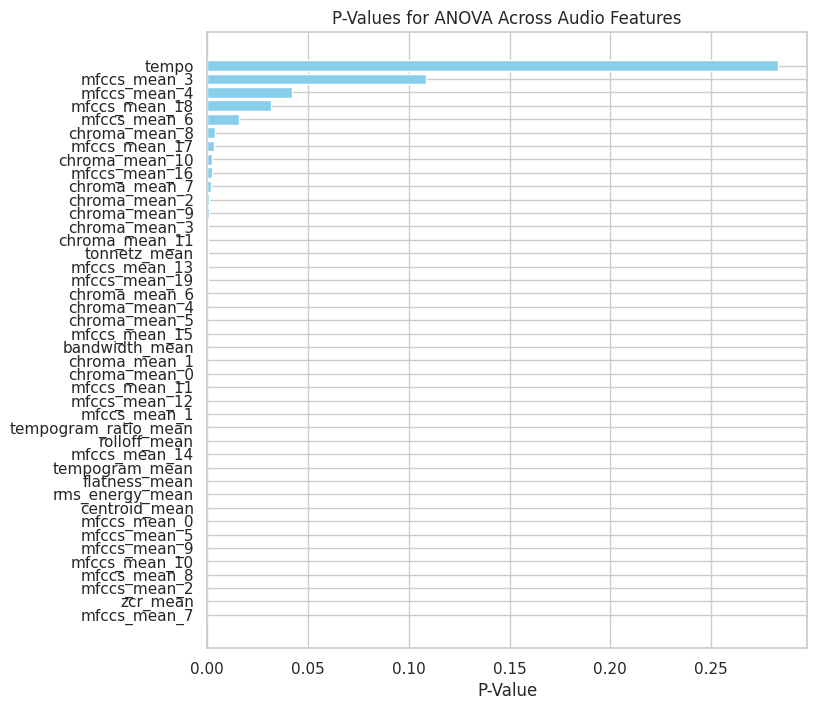

In [20]:
# Assuming 'train_joined_with_audio' is your DataFrame
df = train_joined_with_audio

# Select only the audio feature columns, excluding 'audio_feature_tempo'
audio_features = [col for col in df.columns if col.startswith('audio_feature_')]

# Prepare a list to store ANOVA results
results = []

# Perform ANOVA for each feature and store results in the list
for feature in audio_features:
    grouped_data = [df[df['label'] == label][feature] for label in df['label'].unique()]
    fvalue, pvalue = stats.f_oneway(*grouped_data)
    results.append({'Feature': feature.replace('audio_feature_', ''), 'F-Value': fvalue, 'P-Value': pvalue})

# Convert list to DataFrame
anova_results = pd.DataFrame(results)

# Display the results sorted by p-value to see which features are most statistically significant
anova_results_sorted = anova_results.sort_values(by='P-Value')
print(anova_results_sorted)

# Plot the results for a visual comparison
plt.figure(figsize=(10, 8))  # Increased figure height for better label spacing
plt.barh(anova_results_sorted['Feature'], anova_results_sorted['P-Value'], color='skyblue')
plt.xlabel('P-Value')
plt.title('P-Values for ANOVA Across Audio Features')
plt.gca()  # Invert y axis to have the lowest p-values on top

# Adjust margins and spacing
plt.subplots_adjust(left=0.3)  # Adjust this value as needed to fit your feature names

plt.show()

                 Feature    F-Value       P-Value
15          mfccs_mean_7  66.543817  1.955648e-29
5               zcr_mean  46.326618  9.405423e-21
11          mfccs_mean_2  44.827143  4.156242e-20
16          mfccs_mean_8  40.731690  2.411139e-18
18         mfccs_mean_10  37.392213  6.626432e-17
17          mfccs_mean_9  34.103276  1.735769e-15
13          mfccs_mean_5  30.840313  4.440393e-14
9           mfccs_mean_0  30.052461  9.716445e-14
0          centroid_mean  30.040226  9.835337e-14
4        rms_energy_mean  25.712963  7.272110e-12
2          flatness_mean  21.051139  7.530556e-10
6         tempogram_mean  20.643351  1.130293e-09
22         mfccs_mean_14  20.420596  1.411029e-09
3           rolloff_mean  18.157772  1.344267e-08
7   tempogram_ratio_mean  17.017564  4.187291e-08
10          mfccs_mean_1  13.223101  1.840229e-06
20         mfccs_mean_12  13.046111  2.195512e-06
19         mfccs_mean_11  11.748528  8.010751e-06
28         chroma_mean_0  11.157832  1.444183e-05


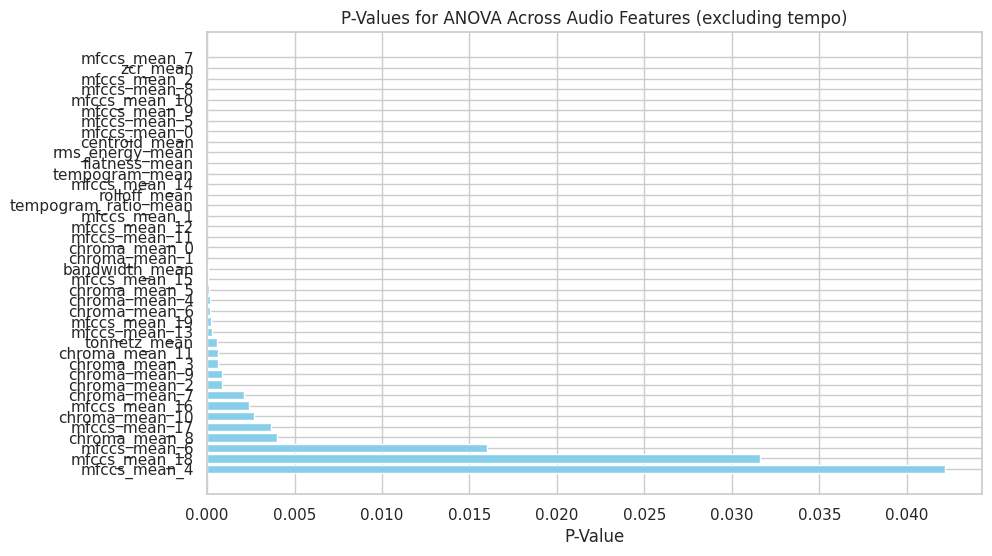

In [12]:
# Assuming 'train_joined_with_audio' is your DataFrame
df = train_joined_with_audio

# Select only the audio feature columns, excluding 'audio_feature_tempo'
audio_features = [col for col in df.columns if col.startswith('audio_feature_') and col != 'audio_feature_tempo' and col != 'audio_feature_mfccs_mean_3']

# Prepare a list to store ANOVA results
results = []

# Perform ANOVA for each feature and store results in the list
for feature in audio_features:
    grouped_data = [df[df['label'] == label][feature] for label in df['label'].unique()]
    fvalue, pvalue = stats.f_oneway(*grouped_data)
    results.append({'Feature': feature.replace('audio_feature_', ''), 'F-Value': fvalue, 'P-Value': pvalue})

# Convert list to DataFrame
anova_results = pd.DataFrame(results)

# Display the results sorted by p-value to see which features are most statistically significant
anova_results_sorted = anova_results.sort_values(by='P-Value')
print(anova_results_sorted)

# Plot the results for a visual comparison
plt.figure(figsize=(10, 6))
plt.barh(anova_results_sorted['Feature'], anova_results_sorted['P-Value'], color='skyblue')
plt.xlabel('P-Value')
plt.title('P-Values for ANOVA Across Audio Features (excluding tempo)')
plt.gca().invert_yaxis()  # Invert y axis to have the lowest p-values on top
plt.show()

In [40]:
def plot_average_filtered_fft(audio_dict, sr, max_freq=5000):
    """
    Computes the average FFT of multiple waveforms stored in a dictionary, and plots the magnitudes up to a specified maximum frequency.
    
    Parameters:
    - audio_dict: Dictionary containing multiple audio data entries. Each entry is expected to have a 'waveforms' key with an audio waveform array.
    - sr: Sample rate of the audio data.
    - max_freq: The maximum frequency to display in the plot.
    """
    sum_fft = None
    count = 0

    for scene_id, data in audio_dict.items():
        waveform = data['waveforms'][0].numpy()  # Extract waveform and convert to numpy array if necessary
        fft_values = np.fft.fft(waveform)
        frequencies = np.fft.fftfreq(len(waveform), 1 / sr)
        magnitudes = np.abs(fft_values)
        
        # Filter to only show up to max_freq
        mask = (frequencies >= 0) & (frequencies <= max_freq)
        filtered_frequencies = frequencies[mask]
        filtered_magnitudes = magnitudes[mask]
        
        # Initialize sum_fft if it's the first scene
        if sum_fft is None:
            sum_fft = np.zeros_like(filtered_magnitudes)
        
        # Sum the FFT magnitudes
        sum_fft += filtered_magnitudes
        count += 1

    # Calculate average FFT
    avg_fft = sum_fft / count

    # Plot the average FFT
    plt.figure(figsize=(10, 5))
    plt.plot(filtered_frequencies, avg_fft)
    plt.title('Average FFT Across All Scenes (Filtered)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Average Amplitude')
    plt.grid(True)
    plt.show()

plot_average_filtered_fft(dev_audio_dict, 44100, 5000)

NameError: name 'dev_audio_dict' is not defined

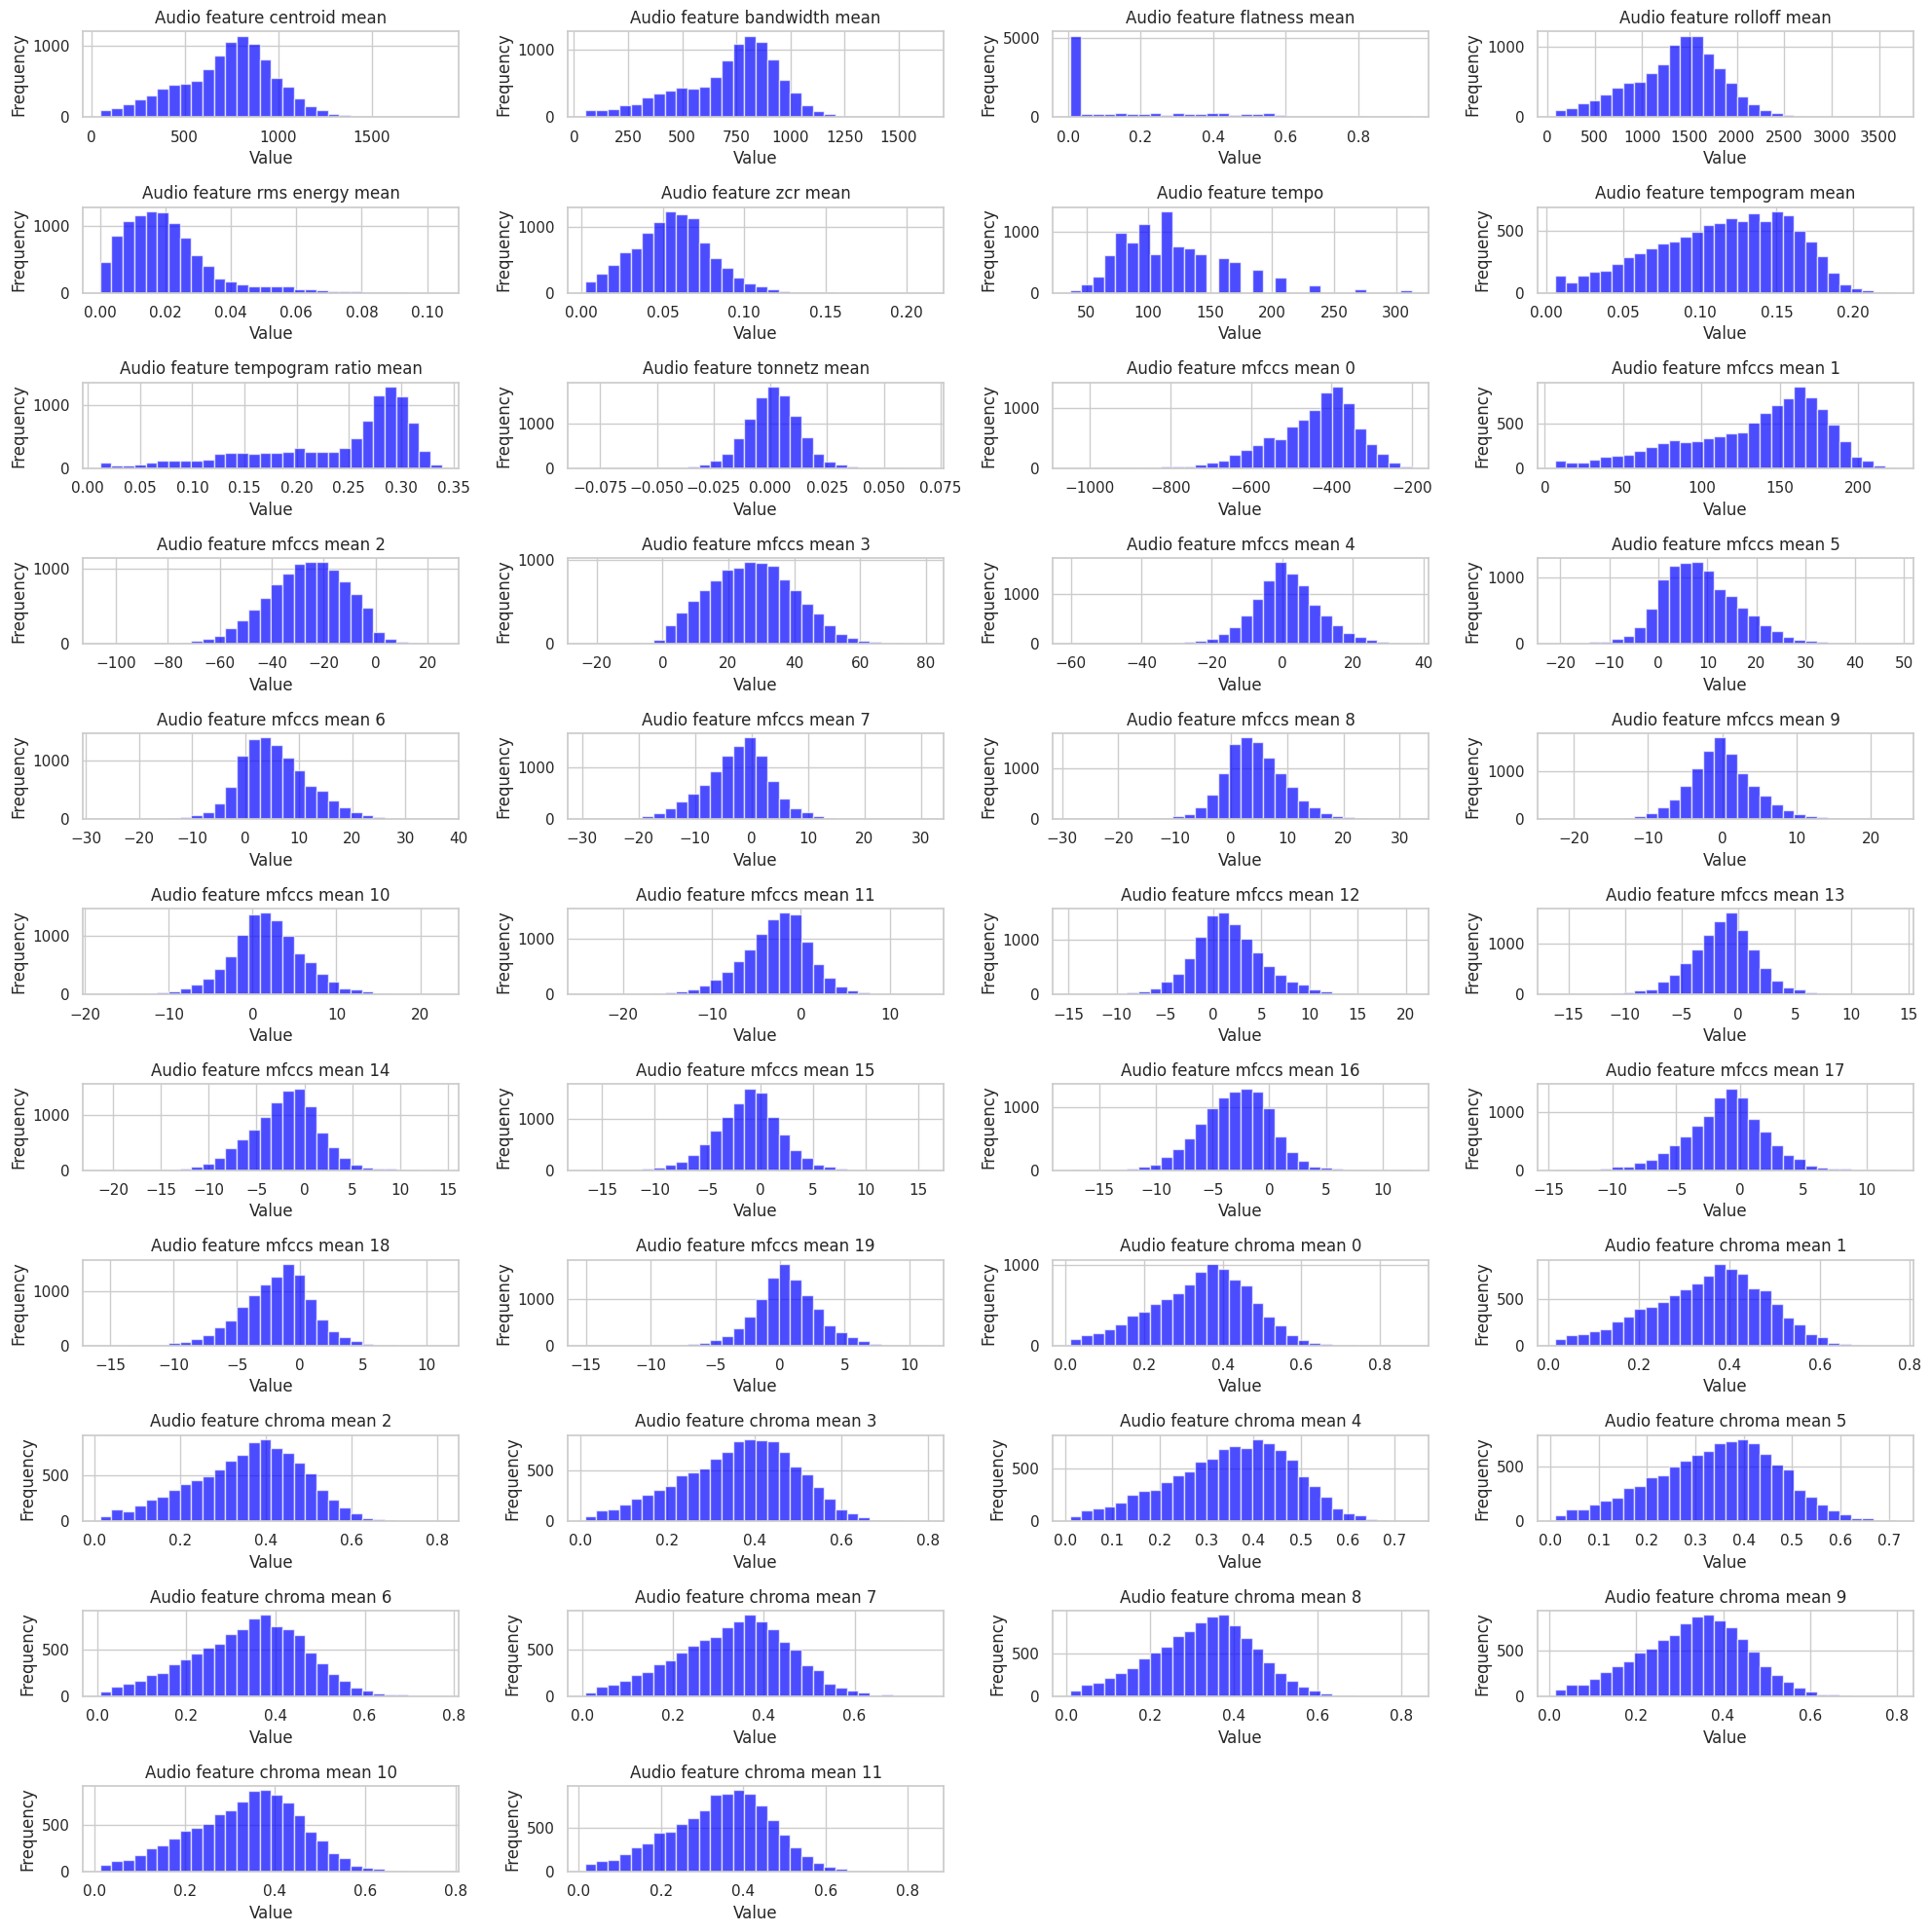

In [36]:
def plot_feature_distributions(feature_data):
    """
    Plots histograms for each spectral feature in the feature DataFrame.
    
    Parameters:
    - feature_data: DataFrame containing the extracted audio features.
    """
    # Prepare the figure layout
    plt.figure(figsize=(20, 20))  # Adjust size as needed for clarity

    # # Automatically fetch all feature names except 'scene_id' if it's part of the DataFrame
    # features = [col for col in feature_data.columns if col not in ['scene_id']]

    # Determine the number of rows and columns for the subplot grid
    total_features = len(audio_features)
    columns = 4  # Number of columns in the plot grid
    rows = (total_features + columns - 1) // columns  # Calculate required number of rows

    # Create subplots for each feature
    for i, feature in enumerate(audio_features):
        ax = plt.subplot(rows, columns, i + 1)
        # Use a consistent number of bins and alpha transparency for clarity
        plt.hist(feature_data[feature], bins=30, alpha=0.7, color='blue')
        plt.title(feature.replace('_', ' ').capitalize())
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.grid(True)

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

plot_feature_distributions(train_joined_with_audio)

In [10]:
with open('../AudioFeaturesExtraction/train_audio_df.pkl', 'rb') as f:
     train_audio_data = pickle.load(f)

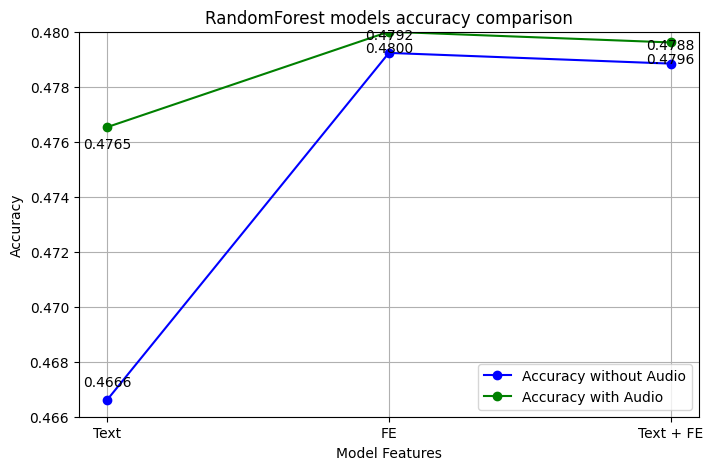

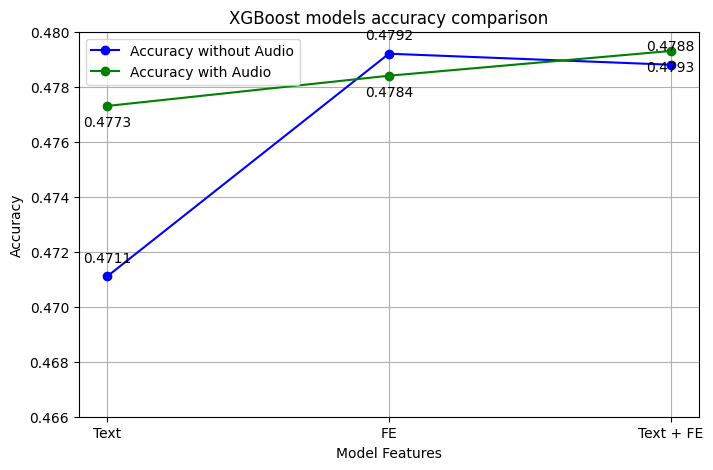

In [6]:
def plot_accuracy_with_values(data, title):
    plt.figure(figsize=(8, 5))
    # Plot the accuracy without audio features
    plt.plot(data['Model Features'], data['Accuracy'], label='Accuracy without Audio', marker='o', color='blue')
    for i, txt in enumerate(data['Accuracy']):
        plt.annotate(f"{txt:.4f}", (data['Model Features'][i], data['Accuracy'][i]), textcoords="offset points", xytext=(0,10), ha='center')
    # Plot the accuracy with audio features
    plt.plot(data['Model Features'], data['Accuracy with Audio features'], label='Accuracy with Audio', marker='o', color='green')
    for i, txt in enumerate(data['Accuracy with Audio features']):
        plt.annotate(f"{txt:.4f}", (data['Model Features'][i], data['Accuracy with Audio features'][i]), textcoords="offset points", xytext=(0,-15), ha='center')
    # Adding labels and title
    plt.xlabel('Model Features')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.ylim(0.466,0.48)
    plt.show()

# Load the Excel file
file_path = '../ModelAccuracy.xlsx'
sheets = ['RandomForest1', 'XGBoost1']

# Read the specified sheets into dataframes
df_random_forest, df_xgboost = [pd.read_excel(file_path, sheet_name=sheet) for sheet in sheets]

# Plotting the data for RandomForest and XGBoost with values next to the dots
plot_accuracy_with_values(df_random_forest, 'RandomForest models accuracy comparison')
plot_accuracy_with_values(df_xgboost, 'XGBoost models accuracy comparison')


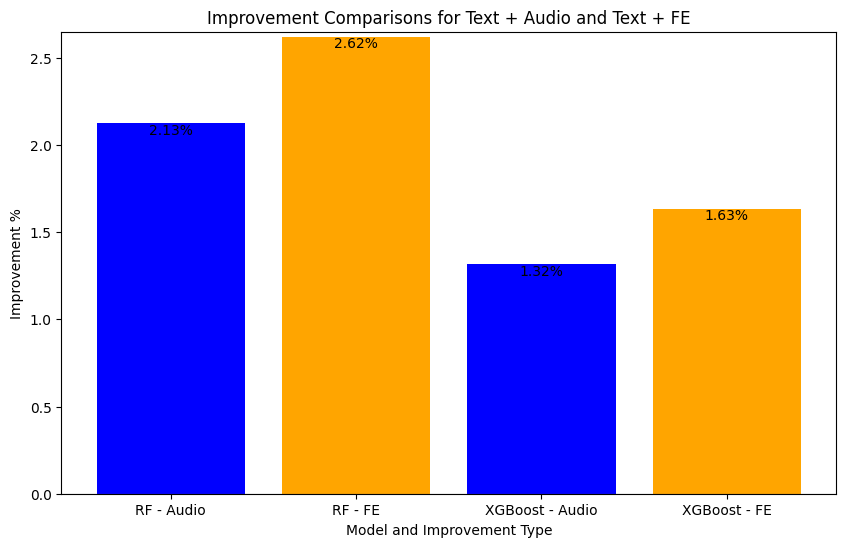

In [7]:
file_path = '../ModelAccuracy.xlsx'

df_random_forest = pd.read_excel(file_path, sheet_name='RandomForest1')
df_xgboost = pd.read_excel(file_path, sheet_name='XGBoost1')

# Calculate specific improvements: Text + Audio vs Text, and Text + FE vs Text
df_random_forest['Text + Audio Improvement %'] = ((df_random_forest.loc[df_random_forest['Model Features'] == 'Text', 'Accuracy with Audio features'].values[0] -
                                                   df_random_forest.loc[df_random_forest['Model Features'] == 'Text', 'Accuracy'].values[0]) /
                                                   df_random_forest.loc[df_random_forest['Model Features'] == 'Text', 'Accuracy'].values[0]) * 100

df_random_forest['Text + FE Improvement %'] = ((df_random_forest.loc[df_random_forest['Model Features'] == 'Text + FE', 'Accuracy'].values[0] -
                                                df_random_forest.loc[df_random_forest['Model Features'] == 'Text', 'Accuracy'].values[0]) /
                                                df_random_forest.loc[df_random_forest['Model Features'] == 'Text', 'Accuracy'].values[0]) * 100

df_xgboost['Text + Audio Improvement %'] = ((df_xgboost.loc[df_xgboost['Model Features'] == 'Text', 'Accuracy with Audio features'].values[0] -
                                             df_xgboost.loc[df_xgboost['Model Features'] == 'Text', 'Accuracy'].values[0]) /
                                             df_xgboost.loc[df_xgboost['Model Features'] == 'Text', 'Accuracy'].values[0]) * 100

df_xgboost['Text + FE Improvement %'] = ((df_xgboost.loc[df_xgboost['Model Features'] == 'Text + FE', 'Accuracy'].values[0] -
                                          df_xgboost.loc[df_xgboost['Model Features'] == 'Text', 'Accuracy'].values[0]) /
                                          df_xgboost.loc[df_xgboost['Model Features'] == 'Text', 'Accuracy'].values[0]) * 100

# Creating a dataframe for plotting
improvement_comparison = pd.DataFrame({
    'Model': ['RF - Audio', 'RF - FE', 'XGBoost - Audio', 'XGBoost - FE'],
    'Improvement %': [
        df_random_forest['Text + Audio Improvement %'].values[0],
        df_random_forest['Text + FE Improvement %'].values[0],
        df_xgboost['Text + Audio Improvement %'].values[0],
        df_xgboost['Text + FE Improvement %'].values[0]
    ]
})

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(improvement_comparison['Model'], improvement_comparison['Improvement %'], color=['blue', 'orange', 'blue', 'orange'])
plt.xlabel('Model and Improvement Type')
plt.ylabel('Improvement %')
plt.ylim(0,2.65)
plt.title('Improvement Comparisons for Text + Audio and Text + FE')
plt.axhline(0, color='gray', linewidth=0.8)  # Add a line at zero for reference

# Annotate the percentage on the bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.2f}%", va='bottom' if yval < 0 else 'top', ha='center')

plt.show()

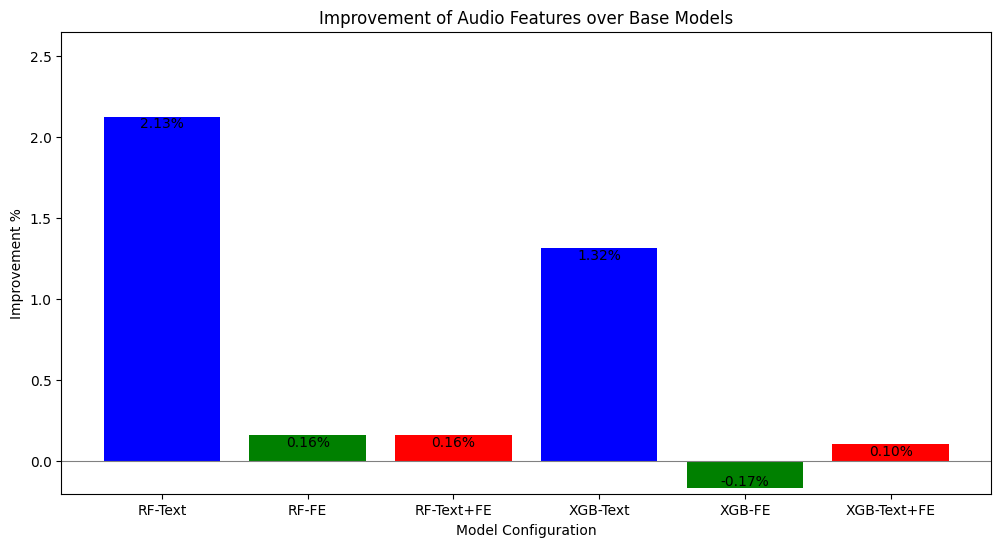

In [9]:
df_random_forest = pd.read_excel(file_path, sheet_name='RandomForest1')
df_xgboost = pd.read_excel(file_path, sheet_name='XGBoost1')

# Calculate the improvements from the root model to its enhancement with audio for each model feature
df_random_forest['Text Improvement %'] = ((df_random_forest.loc[df_random_forest['Model Features'] == 'Text', 'Accuracy with Audio features'].values[0] -
                                           df_random_forest.loc[df_random_forest['Model Features'] == 'Text', 'Accuracy'].values[0]) /
                                           df_random_forest.loc[df_random_forest['Model Features'] == 'Text', 'Accuracy'].values[0]) * 100

df_random_forest['FE Improvement %'] = ((df_random_forest.loc[df_random_forest['Model Features'] == 'FE', 'Accuracy with Audio features'].values[0] -
                                         df_random_forest.loc[df_random_forest['Model Features'] == 'FE', 'Accuracy'].values[0]) /
                                         df_random_forest.loc[df_random_forest['Model Features'] == 'FE', 'Accuracy'].values[0]) * 100

df_random_forest['Text + FE Improvement %'] = ((df_random_forest.loc[df_random_forest['Model Features'] == 'Text + FE', 'Accuracy with Audio features'].values[0] -
                                                df_random_forest.loc[df_random_forest['Model Features'] == 'Text + FE', 'Accuracy'].values[0]) /
                                                df_random_forest.loc[df_random_forest['Model Features'] == 'Text + FE', 'Accuracy'].values[0]) * 100

df_xgboost['Text Improvement %'] = ((df_xgboost.loc[df_xgboost['Model Features'] == 'Text', 'Accuracy with Audio features'].values[0] -
                                     df_xgboost.loc[df_xgboost['Model Features'] == 'Text', 'Accuracy'].values[0]) /
                                     df_xgboost.loc[df_xgboost['Model Features'] == 'Text', 'Accuracy'].values[0]) * 100

df_xgboost['FE Improvement %'] = ((df_xgboost.loc[df_xgboost['Model Features'] == 'FE', 'Accuracy with Audio features'].values[0] -
                                   df_xgboost.loc[df_xgboost['Model Features'] == 'FE', 'Accuracy'].values[0]) /
                                   df_xgboost.loc[df_xgboost['Model Features'] == 'FE', 'Accuracy'].values[0]) * 100

df_xgboost['Text + FE Improvement %'] = ((df_xgboost.loc[df_xgboost['Model Features'] == 'Text + FE', 'Accuracy with Audio features'].values[0] -
                                          df_xgboost.loc[df_xgboost['Model Features'] == 'Text + FE', 'Accuracy'].values[0]) /
                                          df_xgboost.loc[df_xgboost['Model Features'] == 'Text + FE', 'Accuracy'].values[0]) * 100

# Creating a dataframe for plotting
improvement_comparison = pd.DataFrame({
    'Model Configuration': ['RF-Text', 'RF-FE', 'RF-Text+FE', 'XGB-Text', 'XGB-FE', 'XGB-Text+FE'],
    'Improvement %': [
        df_random_forest['Text Improvement %'].values[0],
        df_random_forest['FE Improvement %'].values[0],
        df_random_forest['Text + FE Improvement %'].values[0],
        df_xgboost['Text Improvement %'].values[0],
        df_xgboost['FE Improvement %'].values[0],
        df_xgboost['Text + FE Improvement %'].values[0]
    ]
})

# Plotting
plt.figure(figsize=(12, 6))
colors = ['blue', 'green', 'red', 'blue', 'green', 'red']
bars = plt.bar(improvement_comparison['Model Configuration'], improvement_comparison['Improvement %'], color=colors)
plt.xlabel('Model Configuration')
plt.ylabel('Improvement %')
plt.ylim(-0.2,2.65)
plt.title('Improvement of Audio Features over Base Models')
plt.axhline(0, color='gray', linewidth=0.8)  # Add a line at zero for reference

# Annotate the percentage on the bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.2f}%", va='bottom' if yval < 0 else 'top', ha='center')


plt.show()